Question 1.

Using device: cpu
PyTorch version: 2.9.1
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Model parameters: 390,598

Training...
Epoch 01/10 | Loss: 1.1186 | Train Acc: 56.79% | Test Acc: 64.07%
Epoch 02/10 | Loss: 0.8210 | Train Acc: 69.29% | Test Acc: 72.73%
Epoch 03/10 | Loss: 0.6994 | Train Acc: 74.62% | Test Acc: 74.00%
Epoch 04/10 | Loss: 0.6294 | Train Acc: 77.15% | Test Acc: 77.17%
Epoch 05/10 | Loss: 0.5624 | Train Acc: 79.47% | Test Acc: 79.80%
Epoch 06/10 | Loss: 0.5326 | Train Acc: 80.63% | Test Acc: 79.17%
Epoch 07/10 | Loss: 0.4924 | Train Acc: 82.39% | Test Acc: 79.30%
Epoch 08/10 | Loss: 0.4584 | Train Acc: 83.53% | Test Acc: 81.60%
Epoch 09/10 | Loss: 0.4192 | Train Acc: 84.99% | Test Acc: 81.83%
Epoch 10/10 | Loss: 0.3997 | Train Acc: 85.60% | Test Acc: 82.00%
Training complete!

FINAL TRAIN ACC: 87.39%
FINAL TEST  ACC: 82.00%

CLASSIFICATION REPORT (Test)
              precision    recall  f1-score   support

   buildings       0.88      0.71

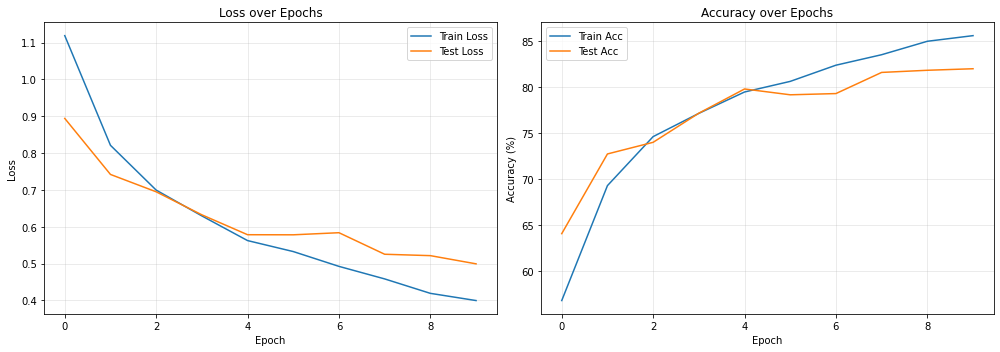

Saved model to intel_q1_cnn.pth


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.rcParams["figure.dpi"] = 72

# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
PATH_TRAIN = 'archive/seg_train/seg_train/'
PATH_TEST  = 'archive/seg_test/seg_test/'

# Image + train params
IMG_SIZE = 64          # (try 128 later if needed)
N_CLASSES = 6
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

# Reglarization params
WEIGHT_DECAY = 0.0     # 0 for baseline
DROPOUT = 0.0          # 0 for baseline

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    torch.backends.cudnn.benchmark = True

# ============================================================================
# DATASETS & DATALOADERS
# ============================================================================

# Simple, stable baseline transforms
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
test_ds  = datasets.ImageFolder(PATH_TEST,  transform=test_tfms)

class_names = train_ds.classes
print("Classes:", class_names)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# ============================================================================
# MODEL
# ============================================================================

class IntelQ1CNN(nn.Module):
    """
    Compact CNN for Q1 baseline.
    """
    def __init__(self, n_classes=6, dropout=0.0):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ============================================================================
# TRAIN / EVAL
# ============================================================================

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(X)
        loss = criterion(logits, y)

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

def train_model():
    model = IntelQ1CNN(n_classes=N_CLASSES, dropout=DROPOUT).to(device)
    print(f"\nModel parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    print("\nTraining...")
    print("=" * 70)

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, criterion, optimizer)
        ts_loss, ts_acc = eval_one_epoch(model, test_dl, criterion)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(ts_loss)
        test_accs.append(ts_acc)

        print(f"Epoch {epoch+1:02d}/{EPOCHS:02d} | "
              f"Loss: {tr_loss:.4f} | Train Acc: {tr_acc:5.2f}% | "
              f"Test Acc: {ts_acc:5.2f}%")

    print("=" * 70)
    print("Training complete!\n")

    return model, (train_losses, train_accs, test_losses, test_accs)

# ============================================================================
# FINAL METRICS + PLOTS
# ============================================================================

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        preds = logits.argmax(1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

def plot_training_curves(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(test_losses, label="Test Loss")
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(train_accs, label="Train Acc")
    ax2.plot(test_accs, label="Test Acc")
    ax2.set_title("Accuracy over Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def main():
    model, curves = train_model()
    train_losses, train_accs, test_losses, test_accs = curves

    # Final evaluation (DataLoader-based, efficient)
    y_train_true, y_train_pred = predict_all(model, train_dl)
    y_test_true,  y_test_pred  = predict_all(model, test_dl)

    print("FINAL TRAIN ACC:", f"{accuracy_score(y_train_true, y_train_pred) * 100:.2f}%")
    print("FINAL TEST  ACC:", f"{accuracy_score(y_test_true,  y_test_pred)  * 100:.2f}%\n")

    print("CLASSIFICATION REPORT (Test)")
    print(classification_report(y_test_true, y_test_pred, target_names=class_names))

    cm = confusion_matrix(y_test_true, y_test_pred)
    print("CONFUSION MATRIX (Test)")
    print(cm)

    plot_training_curves(train_losses, train_accs, test_losses, test_accs)

    # Save model
    torch.save(model.state_dict(), "intel_q1_cnn.pth")
    print("Saved model to intel_q1_cnn.pth")

    return model

if __name__ == "__main__":
    main()

Using device: cpu
PyTorch version: 2.9.1
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Model parameters: 390,598

Training...
Epoch 01/10 | Loss: 1.1363 | Train Acc: 55.61% | Test Acc: 64.87%
Epoch 02/10 | Loss: 0.8315 | Train Acc: 68.42% | Test Acc: 70.53%
Epoch 03/10 | Loss: 0.7459 | Train Acc: 72.69% | Test Acc: 75.23%
Epoch 04/10 | Loss: 0.6534 | Train Acc: 76.17% | Test Acc: 77.37%
Epoch 05/10 | Loss: 0.5957 | Train Acc: 78.54% | Test Acc: 78.63%
Epoch 06/10 | Loss: 0.5478 | Train Acc: 80.28% | Test Acc: 79.37%
Epoch 07/10 | Loss: 0.5178 | Train Acc: 81.77% | Test Acc: 79.83%
Epoch 08/10 | Loss: 0.4899 | Train Acc: 82.65% | Test Acc: 81.73%
Epoch 09/10 | Loss: 0.4618 | Train Acc: 83.68% | Test Acc: 79.23%
Epoch 10/10 | Loss: 0.4390 | Train Acc: 84.69% | Test Acc: 81.23%
Training complete!

FINAL TRAIN ACC: 87.15%
FINAL TEST  ACC: 81.23%

CLASSIFICATION REPORT (Test)
              precision    recall  f1-score   support

   buildings       0.81      0.76

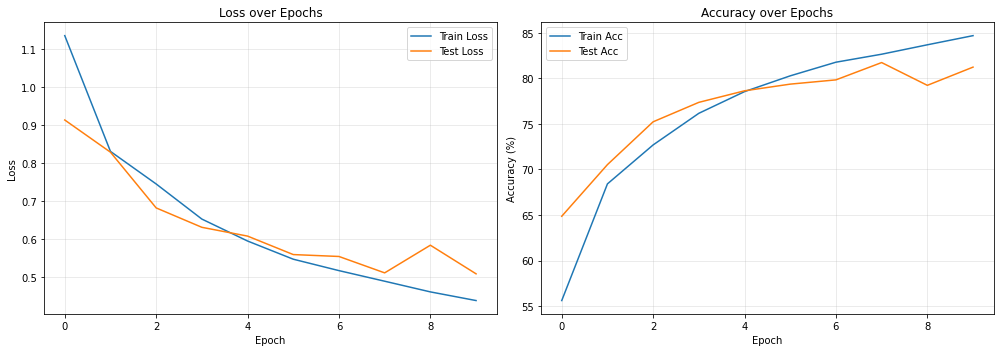

Saved model to intel_q1_cnn.pth


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.rcParams["figure.dpi"] = 72

# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
PATH_TRAIN = 'archive/seg_train/seg_train/'
PATH_TEST  = 'archive/seg_test/seg_test/'

# Image + train params
IMG_SIZE = 64          # (try 128 later if needed)
N_CLASSES = 6
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

# Reglarization params
WEIGHT_DECAY = 0.00005   
DROPOUT = 0.2           

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    torch.backends.cudnn.benchmark = True

# ============================================================================
# DATASETS & DATALOADERS
# ============================================================================

# Simple, stable baseline transforms
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
test_ds  = datasets.ImageFolder(PATH_TEST,  transform=test_tfms)

class_names = train_ds.classes
print("Classes:", class_names)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# ============================================================================
# MODEL
# ============================================================================

class IntelQ1CNN(nn.Module):
    """
     Adding regularization for Q2 baseline.
    """
    def __init__(self, n_classes=6, dropout=0.2):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ============================================================================
# TRAIN / EVAL
# ============================================================================

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(X)
        loss = criterion(logits, y)

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

def train_model():
    model = IntelQ1CNN(n_classes=N_CLASSES, dropout=DROPOUT).to(device)
    print(f"\nModel parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    print("\nTraining...")
    print("=" * 70)

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, criterion, optimizer)
        ts_loss, ts_acc = eval_one_epoch(model, test_dl, criterion)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(ts_loss)
        test_accs.append(ts_acc)

        print(f"Epoch {epoch+1:02d}/{EPOCHS:02d} | "
              f"Loss: {tr_loss:.4f} | Train Acc: {tr_acc:5.2f}% | "
              f"Test Acc: {ts_acc:5.2f}%")

    print("=" * 70)
    print("Training complete!\n")

    return model, (train_losses, train_accs, test_losses, test_accs)

# ============================================================================
# FINAL METRICS + PLOTS
# ============================================================================

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        preds = logits.argmax(1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

def plot_training_curves(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(test_losses, label="Test Loss")
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(train_accs, label="Train Acc")
    ax2.plot(test_accs, label="Test Acc")
    ax2.set_title("Accuracy over Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def main():
    model, curves = train_model()
    train_losses, train_accs, test_losses, test_accs = curves

    # Final evaluation (DataLoader-based, efficient)
    y_train_true, y_train_pred = predict_all(model, train_dl)
    y_test_true,  y_test_pred  = predict_all(model, test_dl)

    print("FINAL TRAIN ACC:", f"{accuracy_score(y_train_true, y_train_pred) * 100:.2f}%")
    print("FINAL TEST  ACC:", f"{accuracy_score(y_test_true,  y_test_pred)  * 100:.2f}%\n")

    print("CLASSIFICATION REPORT (Test)")
    print(classification_report(y_test_true, y_test_pred, target_names=class_names))

    cm = confusion_matrix(y_test_true, y_test_pred)
    print("CONFUSION MATRIX (Test)")
    print(cm)

    plot_training_curves(train_losses, train_accs, test_losses, test_accs)

    # Save model
    torch.save(model.state_dict(), "intel_q1_cnn.pth")
    print("Saved model to intel_q1_cnn.pth")

    return model

if __name__ == "__main__":
    main()

Regularization and dropout reduce overfitting by limiting how strongly the model can adapt to quirks in the training data. As a result, the model’s performance becomes less sensitive to random initialization or mini-batch ordering, which shows up as lower standard deviation across repeated runs. Lower variance implies the model generalizes more consistently and is therefore more robust.

Using device: cpu
PyTorch version: 2.9.1
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Training Q3 (BN + Early Stopping)...


Epoch 01/10 | Train Loss: 0.8068 | Train Acc: 70.95% | Test Loss: 0.7205 | Test Acc: 73.67%
Epoch 02/10 | Train Loss: 0.5807 | Train Acc: 79.28% | Test Loss: 0.6649 | Test Acc: 76.03%
Epoch 03/10 | Train Loss: 0.5032 | Train Acc: 82.11% | Test Loss: 0.5218 | Test Acc: 80.50%
Epoch 04/10 | Train Loss: 0.4422 | Train Acc: 84.20% | Test Loss: 0.5251 | Test Acc: 81.03%
Epoch 05/10 | Train Loss: 0.4111 | Train Acc: 85.75% | Test Loss: 0.5583 | Test Acc: 80.27%
Epoch 06/10 | Train Loss: 0.3691 | Train Acc: 86.97% | Test Loss: 0.4842 | Test Acc: 82.93%
Epoch 07/10 | Train Loss: 0.3349 | Train Acc: 88.05% | Test Loss: 0.6827 | Test Acc: 77.20%
Epoch 08/10 | Train Loss: 0.3061 | Train Acc: 88.88% | Test Loss: 0.4784 | Test Acc: 84.17%
Epoch 09/10 | Train Loss: 0.2855 | Train Acc: 89.70% | Test Loss: 0.5128 | Test Acc: 82.47%
Epoch 10/10 | Train Loss: 0.2484 | Train Acc: 91.19% | Test Loss: 0.4341 | Test Acc: 85.43%
Q3 training complete!

FINAL TRAIN ACC: 94.61%
FINAL TEST  ACC: 85.43%

CLASSIFI

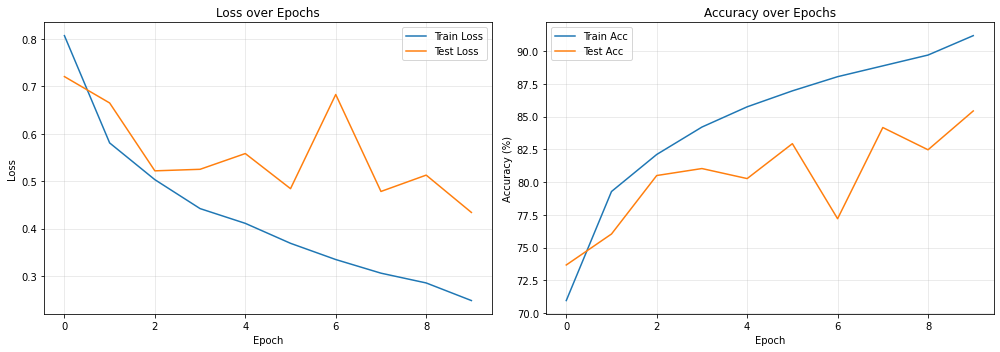

Saved model to intel_q1_cnn.pth


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.rcParams["figure.dpi"] = 72

# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
PATH_TRAIN = 'archive/seg_train/seg_train/'
PATH_TEST  = 'archive/seg_test/seg_test/'

# Image + train params
IMG_SIZE = 64          # (try 128 later if needed)
N_CLASSES = 6
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

# Reglarization params
WEIGHT_DECAY = 0.00005   
DROPOUT = 0.2           

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    torch.backends.cudnn.benchmark = True

# ============================================================================
# DATASETS & DATALOADERS
# ============================================================================

# Simple, stable baseline transforms
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
test_ds  = datasets.ImageFolder(PATH_TEST,  transform=test_tfms)

class_names = train_ds.classes
print("Classes:", class_names)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# ============================================================================
# MODEL
# ============================================================================

class IntelQ1CNN(nn.Module):
    """
     Adding regularization for Q2 baseline.
    """
    def __init__(self, n_classes=6, dropout=0.2):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.best_state = None

    def step(self, current_loss, model):
        # improvement?
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            return False  # do not stop

        self.counter += 1
        return self.counter >= self.patience

    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ============================================================================
# TRAIN / EVAL
# ============================================================================

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(X)
        loss = criterion(logits, y)

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, 100.0 * correct / total

def train_model():
    model = IntelQ1CNN(n_classes=N_CLASSES, dropout=DROPOUT).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY  
    )

    early = EarlyStopping(patience=3, min_delta=1e-4)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    print("\nTraining Q3 (BN + Early Stopping)...")
    print("=" * 70)

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, criterion, optimizer)
        ts_loss, ts_acc = eval_one_epoch(model, test_dl, criterion)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(ts_loss)
        test_accs.append(ts_acc)

        print(f"Epoch {epoch+1:02d}/{EPOCHS:02d} | "
              f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:5.2f}% | "
              f"Test Loss: {ts_loss:.4f} | Test Acc: {ts_acc:5.2f}%")

        # early stopping check on test loss
        if early.step(ts_loss, model):
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            break

    early.restore_best(model)
    print("=" * 70)
    print("Q3 training complete!\n")

    return model, (train_losses, train_accs, test_losses, test_accs)

# ============================================================================
# FINAL METRICS + PLOTS
# ============================================================================

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        preds = logits.argmax(1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

def plot_training_curves(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(test_losses, label="Test Loss")
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(train_accs, label="Train Acc")
    ax2.plot(test_accs, label="Test Acc")
    ax2.set_title("Accuracy over Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def main():
    model, curves = train_model()
    train_losses, train_accs, test_losses, test_accs = curves

    # Final evaluation (DataLoader-based, efficient)
    y_train_true, y_train_pred = predict_all(model, train_dl)
    y_test_true,  y_test_pred  = predict_all(model, test_dl)

    print("FINAL TRAIN ACC:", f"{accuracy_score(y_train_true, y_train_pred) * 100:.2f}%")
    print("FINAL TEST  ACC:", f"{accuracy_score(y_test_true,  y_test_pred)  * 100:.2f}%\n")

    print("CLASSIFICATION REPORT (Test)")
    print(classification_report(y_test_true, y_test_pred, target_names=class_names))

    cm = confusion_matrix(y_test_true, y_test_pred)
    print("CONFUSION MATRIX (Test)")
    print(cm)

    plot_training_curves(train_losses, train_accs, test_losses, test_accs)

    # Save model
    torch.save(model.state_dict(), "intel_q1_cnn.pth")
    print("Saved model to intel_q1_cnn.pth")

    return model

if __name__ == "__main__":
    main()

Conclusion: I strived to get the results of 95% reclassification and 75% testing performance without any hyperparameter tuning, training around 10 epochs in 10 minutes without a GPU. It came close but not quite. The regularization techniques made some improvements. Initially training 10 epochs took about 20 minutes. with lighter weight model i got the time down 16 minutes. Clearly, more epochs and parameters would also improve performance.